## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Embedding, Dropout, Bidirectional
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("/kaggle/input/imdb-movie-ratings-sentiment-analysis/movie.csv")
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [4]:
df.duplicated().sum()

277

In [5]:
df = df.drop_duplicates()

In [6]:
df.label.value_counts()

label
1    19908
0    19815
Name: count, dtype: int64

## Text Preprocessing

In [7]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Text cleaning function
def text_preprocessing(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply text cleaning
df['clean_text']  = df.text.apply(text_preprocessing)

In [8]:
df.head()

,text,label,clean_text
0,I grew up (b. 1965) watching and loving the Th...,0,grew b watching loving thunderbirds mates scho...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chips expectatio...
2,Why do people who do not know what a particula...,0,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movies bor...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dads army fan nothing ever change ...


### Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df.label, test_size=0.2, random_state=42,shuffle=True,stratify=df.label)

print("shape of X_train :", X_train.shape)
print("shape of X_test  :", X_test.shape)
print("shape of y_train :", y_train.shape)
print("shape of y_test  :", y_test.shape)

shape of X_train : (31778,)
shape of X_test  : (7945,)
shape of y_train : (31778,)
shape of y_test  : (7945,)


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

137451

In [11]:
max_len = max([len(seq) for seq in X_train]) 
 
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')
max_len

1440

In [12]:
X_train[0]

array([692, 457,   2, ...,   0,   0,   0], dtype=int32)

In [13]:
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)
y_test_cat

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

## Creating & Training Model

In [14]:
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(units=128, activation='tanh', return_sequences=False)),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')  # For binary classification
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
history = lstm_model.fit(
    X_train, y_train_cat,  
    epochs=5,  
    batch_size=32,  
    validation_split=0.2 
)

Epoch 1/5
795/795 ━━━━━━━━━━━━━━━━━━━━ 87s 101ms/step - accuracy: 0.7256 - loss: 0.5194 - val_accuracy: 0.7882 - val_loss: 0.5273
Epoch 2/5
795/795 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.9335 - loss: 0.1909 - val_accuracy: 0.8671 - val_loss: 0.3653
Epoch 3/5
795/795 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.9765 - loss: 0.0755 - val_accuracy: 0.7708 - val_loss: 0.4850
Epoch 4/5
795/795 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.9760 - loss: 0.0779 - val_accuracy: 0.8529 - val_loss: 0.6376
Epoch 5/5
795/795 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.9944 - loss: 0.0229 - val_accuracy: 0.8557 - val_loss: 0.6097


## Evaluation

In [16]:
# Evaluate LSTM
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test_cat)
print(f"LSTM Accuracy: {lstm_accuracy}")

249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8545 - loss: 0.6222
LSTM Accuracy: 0.852737545967102


## Prediction

249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step


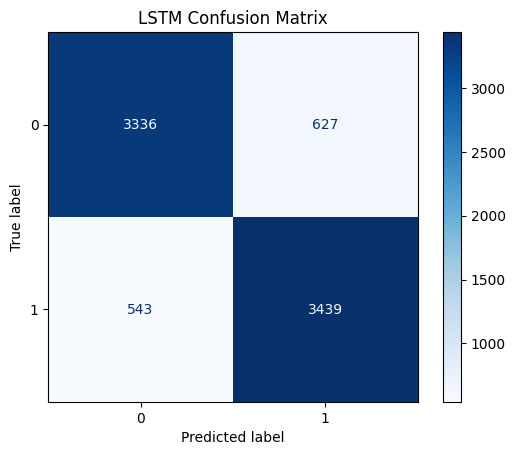

In [17]:
lstm_predictions = lstm_model.predict(X_test)
lstm_pred_labels = np.argmax(lstm_predictions, axis=1)

lstm_cm = confusion_matrix(y_test, lstm_pred_labels)
ConfusionMatrixDisplay(lstm_cm, display_labels=[0, 1]).plot(cmap='Blues')
plt.title("LSTM Confusion Matrix")
plt.show()


In [18]:
# Function to predict sentiment of a new review
def predict_sentiment(review_text, model, tokenizer, max_sequence_length):
    # Clean the text (implement your text_cleaning function here)
    cleaned_text = text_preprocessing(review_text)
    
    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict using the model
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction, axis=1)[0]
    sentiment = "Positive" if predicted_class == 1 else "Negative"
    confidence = prediction[0][predicted_class] * 100
    
    print(f"Review: {review_text}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence * 100:.2f}%\n")


predict_sentiment("This product is amazing and works perfectly!", lstm_model, tokenizer, max_len)
predict_sentiment("Terrible product, would not recommend to anyone.", lstm_model, tokenizer, max_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Review: This product is amazing and works perfectly!
Sentiment: Negative
Confidence: 8047.97%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Review: Terrible product, would not recommend to anyone.
Sentiment: Negative
Confidence: 8428.39%



In [19]:
# Save model and tokenizer
lstm_model.save("lstm_sentiment_model.h5")

import pickle
with open("tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)